# Likelihood Limits

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.stats import expon, norm, uniform, gamma
from scipy import stats
from itertools import product
import numba as nb
from scipy.optimize import fsolve, bisect, minimize
from PIL import Image, ImageDraw
import matplotlib as mpl
from tqdm.auto import tqdm, trange
%config InlineBackend.figure_formats = ['svg']

In [2]:
fontsize = 12

mpl.rcParams['xtick.labelsize'] = fontsize
mpl.rcParams['ytick.labelsize'] = fontsize
mpl.rcParams['font.size'] = fontsize
mpl.rcParams['axes.titlesize'] = fontsize
mpl.rcParams['axes.labelsize'] = fontsize
mpl.rcParams['legend.fontsize'] = fontsize
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

Load the data.

In [3]:
NAMES = ['A', 'B', 'C']
EXPOSURE = np.array([7, 5, 100])
COUNTS = np.array([2100, 1000, 2000])
THRESHOLD_LOW = np.array([0.1, 0.035, 1])
THRESHOLD_UP = np.array([20, 10, 400])
RESOLUTION = np.array([0.015, 0.005, 0.15])
EFFICIENCY = np.array([0.8, 0.65, 0.5])
NMBR_REPETITIONS = 10

In [4]:
data_alice = []
data_bob = []
data_carol = []

for i in range(NMBR_REPETITIONS):
    data_alice.append(np.loadtxt('data/alice/data_alice_{}.txt'.format(i)))
    data_bob.append(np.loadtxt('data/bob/data_bob_{}.txt'.format(i)))
    data_carol.append(np.loadtxt('data/carol/data_carol_{}.txt'.format(i)))
    
grids = []
efficiencies = []

grids.append(np.loadtxt('data/alice/efficiency_alice.txt')[:,0])
grids.append(np.loadtxt('data/bob/efficiency_bob.txt')[:,0])
grids.append(np.loadtxt('data/carol/efficiency_carol.txt')[:,0])

efficiencies.append(np.loadtxt('data/alice/efficiency_alice.txt')[:,1])
efficiencies.append(np.loadtxt('data/bob/efficiency_bob.txt')[:,1])
efficiencies.append(np.loadtxt('data/carol/efficiency_carol.txt')[:,1])

data_alice = np.array(data_alice)
data_bob = np.array(data_bob)
data_carol = np.array(data_carol)
grids = np.array(grids)
efficiencies = np.array(efficiencies)

## Exclusion limits with Likelihood

The picture changes for the calculation of limits with a likelihood fit. For this we first need to define the negative extended log likelihood. 

In [5]:
def inbounds(value, low, up):
    # utility function for bounds checks
    if value < low:
        return False, 10**50 + 10**50*np.abs(value - low)
    elif value > up:
        return False, 10**50 + 10**50*np.abs(value - up)
    else:
        return True, 0
    
def nll(pars, x, *args):
    """
    The negative extended log likelihood.
    
    Arguments:
    x, 
    pars,
    signal_model:object,
    signal_pars:dict,
    grid:list,
    efficiency:list,
    bnds:list,
    density:func,
    sig_fixed:float,
    """
    
    signal_model, signal_pars, grid, efficiency, bnds, density, sig_fixed = args
    
    if sig_fixed is not None:
        pars[0] = sig_fixed
    
    # bounds
    for p, (low, up) in zip(pars, bnds):
        ok, retval = inbounds(p, low, up)
        if not ok:
            return retval
    
    # likelihood
    lh = density(pars, x, *args)
    
    # constraint
    nu = np.trapz(density(pars, grid, *args), x=grid)  # integrate in roi
    return nu - np.sum(np.log(lh))

Next, we define the density functions and signal models for the experiments.

In [6]:
def signal_mod(x, args, **kwargs):
    return expon(scale=args[0]).pdf(x)

In [7]:
def density_alice(pars, 
                  x, 
                  signal_model:object,
                  signal_pars:dict,
                  grid:list,
                  efficiency:list,
                  *args
                  ):
    """
    The density function for experiment A.
    """
    
    # 4 components: signal, flat, peak, rise
    w0, w1, w2, w3, mu, sigma, rise = pars  # 7 pars
    
    # signal
    density = w0 * signal_model(x, **signal_pars)
    #flat
    density += w1 * uniform(scale=20).pdf(x)
    #peak
    density += w2 * norm(loc=mu, scale=sigma).pdf(x)
    #rise
    density += w3 * expon(scale=rise).pdf(x)
    
    #efficiency
    density *= np.interp(x, grid, efficiency)  # for performance use callable function
    
    return density

def density_bob(pars, 
                  x, 
                  signal_model:object,
                  signal_pars:dict,
                  grid:list,
                  efficiency:list,
                  *args
                  ):
    """
    The density function for experiment B.
    """
    
    # 4 components: signal, flat, peak, rise
    w0, w1, w2, w3, mu, sigma, rise = pars  # 7 pars
    
    # signal
    density = w0 * signal_model(x, **signal_pars)
    #flat
    density += w1 * uniform(scale=10).pdf(x)
    #peak
    density += w2 * norm(loc=mu, scale=sigma).pdf(x)
    #rise
    density += w3 * expon(scale=rise).pdf(x)
    
    #efficiency
    density *= np.interp(x, grid, efficiency)
    
    return density

def density_carol(pars, 
                  x, 
                  signal_model:object,
                  signal_pars:dict,
                  grid:list,
                  efficiency:list,
                  *args
                  ):
    """
    The density function for experiment C.
    """
    
    # 7 components: signal, gamma, 5 peaks
    w0, w1, w2, w3, w4, w5, w6, k, delta, mu1, sigma1, mu2, sigma2, mu3, sigma3, mu4, sigma4, mu5, sigma5 = pars  # 19 pars
    
    # signal
    density = w0 * signal_model(x, **signal_pars)
    #gamma
    density += w1 * gamma(a=k, scale=1/delta).pdf(x)
    #peak
    density += w2 * norm(loc=mu1, scale=sigma1).pdf(x)
    #peak
    density += w3 * norm(loc=mu2, scale=sigma2).pdf(x)
    #peak
    density += w4 * norm(loc=mu3, scale=sigma3).pdf(x)
    #peak
    density += w5 * norm(loc=mu4, scale=sigma4).pdf(x)
    #peak
    density += w6 * norm(loc=mu5, scale=sigma5).pdf(x)
    
    #efficiency
    density *= np.interp(x, grid, efficiency)
    
    return density

We need to define bounds, start values and additional arguments for the minimization of the NLL.

In [8]:
LAMB = 1

# experiment A

bnds_alice = [(0, 5e4),  # w0   # bounds from zero to number of events
              (0, 5e4),  # w1
              (0, 5e4),  # w2
              (0, 5e4),  # w3
              (5, 7),  # mu
              (0.3, 0.7),  # sigma
              (0.01, 1),  # rise
             ]

x0_alice = np.array([0.*len(data_alice[0])/EFFICIENCY[0],  # w0
            0.4*len(data_alice[0])/EFFICIENCY[0],  # w1
            0.3*len(data_alice[0])/EFFICIENCY[0],  # w2
            0.3*len(data_alice[0])/EFFICIENCY[0],  # w3 
            6.,  # mu
            0.5,  # sigma
            0.1,  # rise
                    ])

args_alice = (data_alice[0],  # x
              signal_mod,  # signal_model
              # {'args':(LAMB,), 'grid':grids[0], 'efficiency':efficiencies[0], 'exposure':EXPOSURE[0]},  # signal_pars
              {'args':(LAMB,)},  # signal_pars
              grids[0],  # grid
              efficiencies[0],  # efficiency
              bnds_alice,  # bnds
              density_alice,  # density
              None, # sig_fixed
             )

# experiment B

bnds_bob = [(0, 5e4),  # w0 
              (0, 5e4),  # w1
              (0, 5e4),  # w2
              (0, 5e4),  # w3
              (5, 7),  # mu
              (0.3, 0.7),  # sigma
              (0.01, 1),  # rise
             ]

x0_bob = np.array([0.*len(data_bob[0])/EFFICIENCY[1],  # w0
            0.35*len(data_bob[0])/EFFICIENCY[1],  # w1
            0.3*len(data_bob[0])/EFFICIENCY[1],  # w2
            0.35*len(data_bob[0])/EFFICIENCY[1],  # w3 
            6.,  # mu
            0.5,  # sigma
            0.1,  # rise
                  ])

args_bob = (data_bob[0],  # x
              signal_mod,  # signal_model
              # {'args':(LAMB,), 'grid':grids[1], 'efficiency':efficiencies[1], 'exposure':EXPOSURE[1]},  # signal_pars
              {'args':(LAMB,)},  # signal_pars  
              grids[1],  # grid
              efficiencies[1],  # efficiency
              bnds_bob,  # bnds
              density_bob,  # density
              None, # sig_fixed
             )

# experiment C

bnds_carol = [(0, 5e4),  # w0 
              (0, 5e4),  # w1
              (0, 5e4),  # w2
              (0, 5e4),  # w3
              (0, 5e4),  # w4
              (0, 5e4),  # w5
              (0, 5e4),  # w6
              (2, 2.5), # k
              (0.01, 0.02), # delta
              (40, 50),  # mu1
              (1.5, 2.5),  # sigma1
              (70, 80),  # mu2
              (2.5, 3.5),  # sigma2
              (110, 130),  # mu3
              (4.5, 5.5),  # sigma3
              (180, 220),  # mu4
              (9, 11),  # sigma4
              (250, 350),  # mu5
              (18, 22),  # sigma5
             ]

x0_carol = np.array([0.*len(data_carol[0])/EFFICIENCY[2],  # w0
            0.4*len(data_carol[0])/EFFICIENCY[2],  # w1
            0.08*len(data_carol[0])/EFFICIENCY[2],  # w2
            0.12*len(data_carol[0])/EFFICIENCY[2],  # w3 
            0.05*len(data_carol[0])/EFFICIENCY[2],  # w4
            0.15*len(data_carol[0])/EFFICIENCY[2],  # w5
            0.1*len(data_carol[0])/EFFICIENCY[2],  # w6 
            2.25,  # k
            0.014999250037498125,  # delta
            45.,  # mu1
            2.,  # sigma1
            75.,  # mu2
            3.,  # sigma2
            120.,  # mu3
            5.,  # sigma3
            200.,  # mu4
            10.,  # sigma4
            300.,  # mu5
            20.,  # sigma5
                    ])

args_carol = (data_carol[0],  # x
              signal_mod,  # signal_model
              # {'args':(LAMB,), 'grid':grids[2], 'efficiency':efficiencies[2], 'exposure':EXPOSURE[2]},  # signal_pars
              {'args':(LAMB,)},  # signal_pars
              grids[2],  # grid
              efficiencies[2],  # efficiency
              bnds_carol,  # bnds
              density_carol,  # density
              None, # sig_fixed
             )

How does the actual density look like?

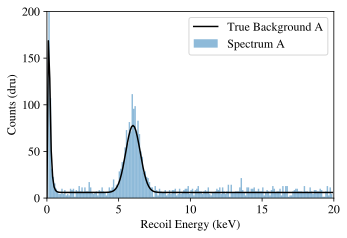

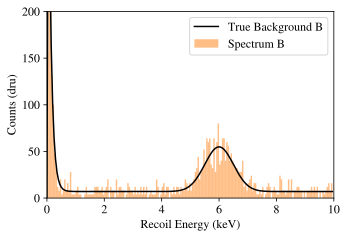

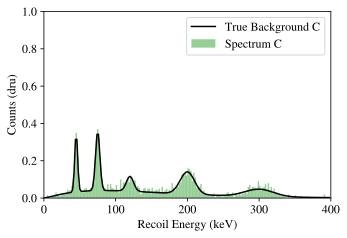

In [9]:
mpl.rcParams['figure.figsize'] = (5, 3.5)

# alice
bin_width = 0.1
ran = (0,20)
bins = np.arange(ran[0],ran[1],bin_width)

plt.hist(data_alice[0], bins=bins, weights=1/bin_width/EXPOSURE[0]*np.ones(len(data_alice[0])), alpha=0.5, label='Spectrum A', range=ran, color='C0')

plt.plot(bins, 
         1/EXPOSURE[0]*density_alice(pars=x0_alice, 
                                                      x=bins, 
                                                      signal_model=signal_mod,
                                                      signal_pars={'args':(LAMB,)},
                                                      grid=grids[0],
                                                      efficiency=efficiencies[0],), 
         color='black', label='True Background A')  #  rise

plt.xlabel('Recoil Energy (keV)')
plt.ylabel('Counts (dru)')
plt.xlim(ran)
plt.ylim(0,200)
plt.legend()
plt.tight_layout()
plt.show()


# bob
bin_width = 0.05
ran = (0,10)
bins = np.arange(ran[0],ran[1],bin_width)

plt.hist(data_bob[0], bins=bins, weights=1/EXPOSURE[1]/bin_width*np.ones(len(data_bob[0])), alpha=0.5, label='Spectrum B', range=ran, color='C1')

plt.plot(bins, 1/EXPOSURE[1]*density_bob(pars=x0_bob, 
                                                      x=bins, 
                                                      signal_model=signal_mod,
                                                      signal_pars={'args':(LAMB,)},
                                                      grid=grids[1],
                                                      efficiency=efficiencies[1],), 
         color='black', label='True Background B')  #  rise

plt.xlabel('Recoil Energy (keV)')
plt.ylabel('Counts (dru)')
plt.xlim(ran)
plt.ylim(0,200)
plt.legend()
plt.tight_layout()
plt.show()


# carol
bin_width = 2
ran = (0,400)
bins = np.arange(ran[0],ran[1],bin_width)

plt.hist(data_carol[0], bins=bins, weights=1/bin_width/EXPOSURE[2]*np.ones(len(data_carol[0])), alpha=0.5, label='Spectrum C', range=ran, color='C2')

eff = np.interp(bins, grids[2], efficiencies[2])
plt.plot(bins, 1/EXPOSURE[2]*density_carol(pars=x0_carol, 
                                                      x=bins, 
                                                      signal_model=signal_mod,
                                                      signal_pars={'args':(LAMB,)},
                                                      grid=grids[2],
                                                      efficiency=efficiencies[2],), 
         color='black', label='True Background C')  #  rise

plt.xlabel('Recoil Energy (keV)')
plt.ylabel('Counts (dru)')
plt.xlim(ran)
plt.ylim(0,1)
plt.legend()
plt.tight_layout()
plt.show()


Get the value for the NLL for the start values (these are the correct background values).

In [10]:
print(nll(x0_alice, *args_alice))
print(nll(x0_bob, *args_bob))
print(nll(x0_carol, *args_carol))

-8905.996306330755
-4288.103588038597
-2099.7477267996837


We do a best fit.

In [11]:
res_alice_best = minimize(nll, 
                          x0=x0_alice, 
                          args=args_alice,
                         ) 

print('Result Alice: ')
print(res_alice_best.x)
print(res_alice_best.fun)

res_bob_best = minimize(nll, 
                          x0=x0_bob, 
                          args=args_bob,
                         )

print('Result Bob: ')
print(res_bob_best.x)
print(res_bob_best.fun)

res_carol_best = minimize(nll, 
                          x0=x0_carol, 
                          args=args_carol,
                         )

print('Result Carol: ')
print(res_carol_best.x)
print(res_carol_best.fun)

Result Alice: 
[2.79200480e-01 1.25214050e+03 9.48397473e+02 8.20298315e+02
 5.99363767e+00 5.23601892e-01 1.07201911e-01]
-8948.267642871808
Result Bob: 
[8.73439284e-02 6.22236558e+02 5.06518421e+02 6.11314044e+02
 5.99256250e+00 5.36532390e-01 9.00657653e-02]
-4295.98373639238
Result Carol: 
[1.64212157e-02 1.60001319e+03 3.20001887e+02 4.80004268e+02
 2.00001219e+02 6.00004970e+02 4.00017827e+02 2.28003621e+00
 1.57479317e-02 4.47450465e+01 2.13295558e+00 7.50083238e+01
 2.97559351e+00 1.19913569e+02 5.45175402e+00 2.00248412e+02
 1.03436300e+01 3.00062523e+02 1.97249898e+01]
-2105.2982905224567


How does the best fit look like?

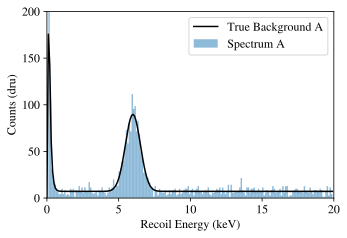

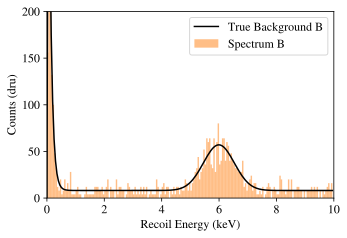

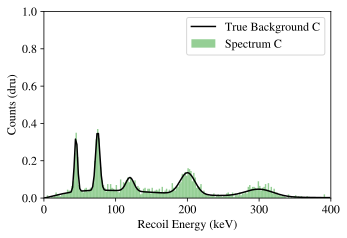

In [12]:
mpl.rcParams['figure.figsize'] = (5, 3.5)

# alice
bin_width = 0.1
ran = (0,20)
bins = np.arange(ran[0],ran[1],bin_width)

plt.hist(data_alice[0], bins=bins, weights=1/bin_width/EXPOSURE[0]*np.ones(len(data_alice[0])), alpha=0.5, label='Spectrum A', range=ran, color='C0')

plt.plot(bins, 
         1/EXPOSURE[0]*density_alice(pars=res_alice_best.x, 
                                                      x=bins, 
                                                      signal_model=signal_mod,
                                                      signal_pars={'args':(LAMB,)},
                                                      grid=grids[0],
                                                      efficiency=efficiencies[0],), 
         color='black', label='True Background A')  #  rise

plt.xlabel('Recoil Energy (keV)')
plt.ylabel('Counts (dru)')
plt.xlim(ran)
plt.ylim(0,200)
plt.legend()
plt.tight_layout()
plt.show()


# bob
w0, w1, w2, w3, mu, sigma, rise = x0_bob

bin_width = 0.05
ran = (0,10)
bins = np.arange(ran[0],ran[1],bin_width)

plt.hist(data_bob[0], bins=bins, weights=1/EXPOSURE[1]/bin_width*np.ones(len(data_bob[0])), alpha=0.5, label='Spectrum B', range=ran, color='C1')

plt.plot(bins, 1/EXPOSURE[1]*density_bob(pars=res_bob_best.x, 
                                                      x=bins, 
                                                      signal_model=signal_mod,
                                                      signal_pars={'args':(LAMB,)},
                                                      grid=grids[1],
                                                      efficiency=efficiencies[1],), 
         color='black', label='True Background B')  #  rise

plt.xlabel('Recoil Energy (keV)')
plt.ylabel('Counts (dru)')
plt.xlim(ran)
plt.ylim(0,200)
plt.legend()
plt.tight_layout()
plt.show()


# carol
bin_width = 2
ran = (0,400)
bins = np.arange(ran[0],ran[1],bin_width)

plt.hist(data_carol[0], bins=bins, weights=1/bin_width/EXPOSURE[2]*np.ones(len(data_carol[0])), alpha=0.5, label='Spectrum C', range=ran, color='C2')

eff = np.interp(bins, grids[2], efficiencies[2])
plt.plot(bins, 1/EXPOSURE[2]*density_carol(pars=res_carol_best.x, 
                                                      x=bins, 
                                                      signal_model=signal_mod,
                                                      signal_pars={'args':(LAMB,)},
                                                      grid=grids[2],
                                                      efficiency=efficiencies[2],), 
         color='black', label='True Background C')  #  rise

plt.xlabel('Recoil Energy (keV)')
plt.ylabel('Counts (dru)')
plt.xlim(ran)
plt.ylim(0,1)
plt.legend()
plt.tight_layout()
plt.show()


Now we calculate the exclusion limit.

In [13]:
def get_root(implf, a):
    
    b = 1
    while True:
        try: 
            retval = bisect(implfunc_alice, a=res_alice_best.x[0], b=1)
        except:
            b *= 10
            # if b > 1e6:
            #     raise ValueError('The upper limit is too high!')
    return retval

In [17]:
do = [0,1,2]

# alice

if 0 in do:

    def implfunc_alice(val): 

        args_alice_excl = (data_alice[0],  # x
                  signal_mod,  # signal_model
                  {'args':(LAMB,), 'grid':grids[0], 'efficiency':efficiencies[0], 'exposure':EXPOSURE[0]},  # signal_pars
                  grids[0],  # grid
                  efficiencies[0],  # efficiency
                  bnds_alice,  # bnds
                  density_alice,  # density
                  val, # sig_fixed
                 )

        return minimize(nll, x0=res_alice_best.x, args=args_alice_excl).fun + res_alice_best.fun + 1.282**2/2

    res_alice_excl = bisect(implfunc_alice, a=res_alice_best.x[0], b=1e8)
    # res_alice_excl = get_root(implfunc_alice, a=res_alice_best.x[0])

    print(res_alice_excl)

# bob

if 1 in do:

    def implfunc_bob(val): 

        args_bob_excl = (data_bob[0],  # x
                  signal_mod,  # signal_model
                  {'args':(LAMB,), 'grid':grids[1], 'efficiency':efficiencies[1], 'exposure':EXPOSURE[1]},  # signal_pars
                  grids[1],  # grid
                  efficiencies[1],  # efficiency
                  bnds_bob,  # bnds
                  density_bob,  # density
                  val, # sig_fixed
                 )

        return minimize(nll, x0=res_bob_best.x, args=args_bob_excl).fun + res_bob_best.fun + 1.282**2/2

    res_bob_excl = bisect(implfunc_bob, a=res_bob_best.x[0], b=1e8)  # TODO get_root

    print(res_bob_excl)

# carol

if 2 in do:

    def implfunc_carol(val): 

        args_carol_excl = (data_carol[0],  # x
                  signal_mod,  # signal_model
                  {'args':(LAMB,), 'grid':grids[2], 'efficiency':efficiencies[2], 'exposure':EXPOSURE[2]},  # signal_pars
                  grids[2],  # grid
                  efficiencies[2],  # efficiency
                  bnds_carol,  # bnds
                  density_carol,  # density
                  val, # sig_fixed
                 )

        return minimize(nll, x0=res_carol_best.x, args=args_carol_excl).fun + res_carol_best.fun + 1.282**2/2

    res_carol_excl = bisect(implfunc_carol, a=res_carol_best.x[0], b=1e8)  # TODO get_root

    print(res_carol_excl)
    
# plot the nu ingegral value ??

27592.35627410465
15636.688990270472
22789.535797706754


For the correct normalization, we need to divide by the number of events and multiply by the exposure.

In [18]:
print(res_alice_excl/COUNTS[0]*EXPOSURE[0])
print(res_alice_excl/COUNTS[1]*EXPOSURE[1])
print(res_alice_excl/COUNTS[2]*EXPOSURE[2])  # grid bin width problem ???

91.97452091368217
137.96178137052325
1379.6178137052327


Lets streamline the whole procedure and speed it up.

In [19]:
import numba as nb
from math import gamma as ga
from numba import vectorize, float64, njit
SQRT2PI = np.sqrt(2.0 * np.pi)

# normal distribution
@njit
def pdf_normal(x, loc=0., scale=1.):
    u = (x - loc) / scale
    return np.exp(-0.5 * u ** 2) / (SQRT2PI * scale)
    
# exponential distribution
@njit
def pdf_expon(x, scale=1.):
    if 0 < x:
        return scale*np.exp(-scale*x)
    return 0

# uniform distribution
@njit
def pdf_uniform(x, loc=0., scale=1.):
    if loc <= x <= loc + scale:
        return 1 / scale
    return 0

# gamma distribution
@njit
def pdf_gamma(x, a=1., scale=1.):
    u = x ** (a - 1) * np.exp( - x / scale)
    return u / ga(a) / scale ** a

In [20]:
@njit
def density_alice_nb(pars, 
                  x, 
                  lamb,
                  efficiency
                  ):
    """
    The density function for experiment A.
    """
    
    density = np.zeros(len(x))

    for i,v in enumerate(x):
        # signal
        density[i] += pars[0] * pdf_expon(v, lamb)
        #flat
        density[i] += pars[1] * pdf_uniform(v, loc=0., scale=20.)
        #peak
        density[i] += pars[2] * pdf_normal(v, loc=pars[4], scale=pars[5])
        #rise
        density[i] += pars[3] * pdf_expon(v, scale=pars[6])
    
    #efficiency
    density *= efficiency
    
    return density

@njit
def density_bob_nb(pars, 
                  x, 
                  lamb,
                  efficiency
                  ):
    """
    The density function for experiment B.
    """
    
    density = np.zeros(len(x))

    for i,v in enumerate(x):  
        # signal
        density[i] += pars[0] * pdf_expon(v, lamb)
        #flat
        density[i] += pars[1] * pdf_uniform(v, loc=0., scale=10.)
        #peak
        density[i] += pars[2] * pdf_normal(v, loc=pars[4], scale=pars[5])
        #rise
        density[i] += pars[3] * pdf_expon(v, scale=pars[6])
    
    #efficiency
    density *= efficiency
    
    return density

@njit
def density_carol_nb(pars, 
                  x, 
                  lamb,
                  efficiency
                  ):
    """
    The density function for experiment C.
    """
    
    density = np.zeros(len(x))

    for i,v in enumerate(x):  
        # signal
        density[i] += pars[0] * pdf_expon(v, lamb)
        #gamma
        density[i] += pars[1] * pdf_gamma(v, a=pars[7], scale=1/pars[8])
        #peak
        density[i] += pars[2] * pdf_normal(v, loc=pars[9], scale=pars[10])
        #peak
        density[i] += pars[3] * pdf_normal(v, loc=pars[11], scale=pars[12])
        #peak
        density[i] += pars[4] * pdf_normal(v, loc=pars[13], scale=pars[14])
        #peak
        density[i] += pars[5] * pdf_normal(v, loc=pars[15], scale=pars[16])
        #peak
        density[i] += pars[6] * pdf_normal(v, loc=pars[17], scale=pars[18])
    
    #efficiency
    density *= efficiency
    
    return density

In [21]:
def nll_combined(pars, x, lamb, densities, grid, eff_grid, efficiencies, sig_fixed, bnds, npars):
    """
    The negative extended log likelihood.
    
    grid: 1D array, the grid over the combined ROI of all measurements for the integration
    eff_grid: list of 1D arrays, the efficiencies of the measurements, evaluated at the grid values, 
        set to zero outside the ROI of the measurement
    efficiencies: list of 1D arrays, the efficiencies of the measurements, evaluated at the x values, 
        set to zero outside the ROI of the measurement
    """
    
    n = len(npars)  # the number of densities/measurements
    lh = 0  # init the count variable for the likelihood
    nu = 0  # init the count variable for the integral over the density
    
    # loop over the measurements
    for i in range(n):
    
        # get the correct pars and bounds for this measurement
        pars_ = pars[int(np.sum(npars[:i])):int(np.sum(npars[:i+1]))]
        bnds_ = bnds[int(np.sum(npars[:i])):int(np.sum(npars[:i+1]))]
        
        # if the signal weight is fixed, set it for all the densities
        if sig_fixed is not None:
            pars_[0] = sig_fixed/n
    
        # check if the parameters are within their bounds
        for p, (low, up) in zip(pars_, bnds_):
            ok, retval = inbounds(p, low, up)
            if not ok:
                return retval
    
        # calculate and sum up the likelihood and the integral over the density
        
        lh += densities[i](pars_, x, lamb, efficiencies[i])
        nu += np.trapz(y=densities[i](pars_, grid, lamb, eff_grid[i]), x=grid)  # integrate in roi
        
    return nu - np.sum(np.log(lh))

In [22]:
args_ = (data_alice[0],  # x
         1,  # lamb
         [density_alice_nb],
         grids[0],  # grid
         efficiencies[0],  # eff_grid
         [np.interp(data_alice[0], grids[0], efficiencies[0], left=0, right=0)],  # efficiency
         None,# sig_fixed
         bnds_alice,  # bnds
         [len(x0_alice)],  # npars
         )

print(nll_combined(x0_alice, *args_))

args_ = (data_bob[0],  # x
         1,  # lamb
         [density_bob_nb],
         grids[1],  # grid
         efficiencies[1],  # eff_grid
         [np.interp(data_bob[0], grids[1], efficiencies[1], left=0, right=0)],  # efficiency
         None,# sig_fixed
         bnds_bob,  # bnds
         [len(x0_bob)],  # npars
         )

print(nll_combined(x0_bob, *args_))

args_ = (data_carol[0],  # x
         1,  # lamb
         [density_carol_nb],
         grids[2],  # grid
         efficiencies[2],  # eff_grid
         [np.interp(data_carol[0], grids[2], efficiencies[2], left=0, right=0)],  # efficiency
         None,# sig_fixed
         bnds_carol,  # bnds
         [len(x0_carol)],  # npars
         )

print(nll_combined(x0_carol, *args_))

-10459.031475205515
-4610.179700308886
-3879.7097937258545


In [23]:
def get_limit_lh(dm_pars, densities, x0s, datas, grids, efficiencies, 
                 exposures, bndss):
    
    # get the number of measurements
    npars = [len(x0) for x0 in x0s]
    
    # combine all start values, datas and bounds into a 1D array
    x0s = np.hstack(x0s)
    bnds = []  # TODO here could be an error??
    for b in bndss:
        bnds = bnds + [v for v in b]
        
    # produce a grid in the combined ROI for the integration of density
    grid = np.linspace(np.min(np.hstack(grids)), np.max(np.hstack(grids)), 10000)
        
    # here we start with the actual limit calculation
    limit = []    
    for p in tqdm(dm_pars):
        
        # the nll_combined function takes 9 arguments additionally to the parameters
        args_ = (np.sort(np.hstack(datas)),  # x
                 p,  # lamb
                 densities,
                 grid,  # grid
                 [np.interp(grid,g,e,left=0,right=0) for g,e in zip(grids,efficiencies)],  # eff_grid
                 [np.interp(np.sort(d),g,e) for d,g,e in zip(datas,grids,efficiencies)],  # efficiency
                 None,# sig_fixed
                 bnds,  # bnds
                 npars,  # npars
                 )
    
        # calculate best fit
        res_best = minimize(nll_combined, 
                            x0=x0s, 
                            args=args_,
                            )
        
        # print('Res best: ', res_best)

        # do exclusion fit
        def implfunc(val): 

            # the nll_combined function takes 9 arguments additionally to the parameters
            args_excl = (np.sort(np.hstack(datas)),  # x
                 p,  # lamb
                 densities,
                 grid,  # grid
                 [np.interp(grid,g,e,left=0,right=0) for g,e in zip(grids,efficiencies)],  # eff_grid
                 [np.interp(d,g,e) for d,g,e in zip(datas,grids,efficiencies)],  # efficiency
                 val,# sig_fixed
                 bnds,  # bnds
                 npars,  # npars
                 )
            
            res = minimize(nll_combined, x0=res_best.x, args=args_excl)
            
            # print(res.x)

            return res.fun + res_best.fun + 1.282**2/2

        res_excl = bisect(implfunc, a=res_best.x[0], b=1e6)

        limit.append(res_excl)
    
    return limit

Test function.

In [26]:
get_limit_lh(dm_pars=[1], 
             densities=[density_alice_nb,], 
             x0s=[x0_alice,], 
             datas=[data_alice[0],],
             grids=grids[[0,]], 
             efficiencies=efficiencies[[0,]], 
             exposures=EXPOSURE[[0,]], 
             bndss=[bnds_alice,])/COUNTS[0]*EXPOSURE[0]

array([87.77546081])

Test for multiple measurements.

In [27]:
get_limit_lh(dm_pars=[1], 
             densities=[density_alice_nb, density_bob_nb], 
             x0s=[x0_alice, x0_bob], 
             datas=[data_alice[0], data_bob[0]],
             grids=grids[[0,1]], 
             efficiencies=efficiencies[[0,1]], 
             exposures=EXPOSURE[[0,1]], 
             bndss=[bnds_alice, bnds_bob])/(COUNTS[0] + COUNTS[1])*(EXPOSURE[0] + EXPOSURE[1])

<ipython-input-21-2dc8ff6c7d90>:38: RuntimeWarning: divide by zero encountered in log
  return nu - np.sum(np.log(lh))
<ipython-input-21-2dc8ff6c7d90>:38: RuntimeWarning: invalid value encountered in log
  return nu - np.sum(np.log(lh))
<ipython-input-21-2dc8ff6c7d90>:38: RuntimeWarning: invalid value encountered in log
  return nu - np.sum(np.log(lh))
<ipython-input-21-2dc8ff6c7d90>:38: RuntimeWarning: invalid value encountered in log
  return nu - np.sum(np.log(lh))
<ipython-input-21-2dc8ff6c7d90>:38: RuntimeWarning: divide by zero encountered in log
  return nu - np.sum(np.log(lh))
<ipython-input-21-2dc8ff6c7d90>:38: RuntimeWarning: invalid value encountered in log
  return nu - np.sum(np.log(lh))
<ipython-input-21-2dc8ff6c7d90>:38: RuntimeWarning: invalid value encountered in log
  return nu - np.sum(np.log(lh))
<ipython-input-21-2dc8ff6c7d90>:38: RuntimeWarning: divide by zero encountered in log
  return nu - np.sum(np.log(lh))
<ipython-input-21-2dc8ff6c7d90>:38: RuntimeWarning: i

<ipython-input-21-2dc8ff6c7d90>:38: RuntimeWarning: invalid value encountered in log
  return nu - np.sum(np.log(lh))
<ipython-input-21-2dc8ff6c7d90>:38: RuntimeWarning: divide by zero encountered in log
  return nu - np.sum(np.log(lh))


array([6.71505862e-15])

Finally, some combined limits.

In [ ]:
num=70

print('Calculate individual Limits...')
pars_alice = np.logspace(-1.5,1,num=num)  # upper is 1
pars_bob = np.logspace(-2,1,num=num)
pars_carol = np.logspace(-0.5,2,num=num)

limit_alice = [get_limit_lh(pars=pars_alice, 
                 densities=[density_alice], 
                 x0s=[x0_alice], 
                 datas=[data_alice[i]],
                 grids=grids[[0]], 
                 efficiencies=efficiencies[[0]], 
                 exposures=EXPOSURE[[0]], 
                 bndss=[bnds_alice]) for i in range(NMBR_REPETITIONS)]  # NMBR_REPETITIONS

# limit_bob = [get_limit_lh(pars=pars_bob, 
#                  densities=[density_bob], 
#                  x0s=[x0_bob], 
#                  datas=[data_bob[i]],
#                  grids=grids[[1]], 
#                  efficiencies=efficiencies[[1]], 
#                  exposures=EXPOSURE[[1]], 
#                  bndss=[bnds_bob]) for i in range(NMBR_REPETITIONS)]

# limit_carol = [get_limit_lh(pars=pars_carol, 
#                  densities=[density_carol], 
#                  x0s=[x0_carol], 
#                  datas=[data_carol[i]],
#                  grids=grids[[2]], 
#                  efficiencies=efficiencies[[2]], 
#                  exposures=EXPOSURE[[2]], 
#                  bndss=[bnds_carol]) for i in range(NMBR_REPETITIONS)]

# print('Calculate two-experiment Limits...')
# pars_ab = np.logspace(-2,1,num=num)
# pars_ac = np.logspace(-1.5,1.8,num=num)
# pars_bc = np.logspace(-2,2,num=num)

# limit_ab = [get_limit(pars_ab, [data_alice[i], data_bob[i]], 
#                         grids=grids[[0,1]], 
#                         efficiencies=efficiencies[[0,1]], 
#                         signal_model=sig_combined,
#                         exposures=EXPOSURE[[0,1]], 
#                         thresholds_low=THRESHOLD_LOW[[0,1]], 
#                         thresholds_up=THRESHOLD_UP[[0,1]], 
#                         resolutions=RESOLUTION[[0,1]]) for i in range(NMBR_REPETITIONS)]

# limit_ac = [get_limit(pars_ac, [data_alice[i], data_carol[i]], 
#                         grids=grids[[0,2]], 
#                         efficiencies=efficiencies[[0,2]], 
#                         signal_model=sig_combined,
#                         exposures=EXPOSURE[[0,2]], 
#                         thresholds_low=THRESHOLD_LOW[[0,2]], 
#                         thresholds_up=THRESHOLD_UP[[0,2]], 
#                         resolutions=RESOLUTION[[0,2]]) for i in range(NMBR_REPETITIONS)]

# limit_bc = [get_limit(pars_bc, [data_bob[i], data_carol[i]], 
#                         grids=grids[[1,2]], 
#                         efficiencies=efficiencies[[1,2]], 
#                         signal_model=sig_combined,
#                         exposures=EXPOSURE[[1,2]], 
#                         thresholds_low=THRESHOLD_LOW[[1,2]], 
#                         thresholds_up=THRESHOLD_UP[[1,2]], 
#                         resolutions=RESOLUTION[[1,2]]) for i in range(NMBR_REPETITIONS)]

# print('Calculate combined Limit ...')
# pars_all = np.logspace(-2,2,num=num)

# limit_all = [get_limit(pars_all, [data_alice[i], data_bob[i], data_carol[i]], 
#                       grids, efficiencies, sig_combined, 
#                       EXPOSURE, THRESHOLD_LOW, THRESHOLD_UP, RESOLUTION) for i in range(NMBR_REPETITIONS)]


And lets do some plots.

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,5), sharex=True, sharey=True)

axes[0].loglog(pars_alice, np.quantile(limit_alice, q=0.5, axis=0), label='Limit ' + NAMES[0], linewidth=2, color='C0')
# axes[0].loglog(pars_bob, np.quantile(limit_bob, q=0.5, axis=0), label='Limit ' + NAMES[1], linewidth=2, color='C1')
# axes[0].loglog(pars_carol, np.quantile(limit_carol, q=0.5, axis=0), label='Limit ' + NAMES[2], linewidth=2, color='C2')
axes[0].fill_between(pars_alice, y1=np.quantile(limit_alice, q=0.75, axis=0),
                    y2=np.quantile(limit_alice, q=0.25, axis=0), color='C0', alpha=0.3)
# axes[0].fill_between(pars_bob, y1=np.quantile(limit_bob, q=0.75, axis=0),
#                    y2=np.quantile(limit_bob, q=0.25, axis=0), color='C1', alpha=0.3)
# axes[0].fill_between(pars_carol, y1=np.quantile(limit_carol, q=0.75, axis=0),
#                     y2=np.quantile(limit_carol, q=0.25, axis=0), color='C2', alpha=0.3)
axes[0].legend(loc='lower left')

# axes[1].loglog(pars_alice, np.quantile(limit_alice, q=0.5, axis=0), linewidth=1, linestyle='dotted', color='C0')
# axes[1].loglog(pars_bob, np.quantile(limit_bob, q=0.5, axis=0), linewidth=1, linestyle='dotted', color='C1')
# axes[1].loglog(pars_carol, np.quantile(limit_carol, q=0.5, axis=0), linewidth=1, linestyle='dotted', color='C2')
# axes[1].loglog(pars_ab, np.quantile(limit_ab, q=0.5, axis=0), label='Limit ' + NAMES[0] + ', ' + NAMES[1], color='C3', zorder=15)
# axes[1].loglog(pars_bc, np.quantile(limit_bc, q=0.5, axis=0), label='Limit ' + NAMES[1] + ', ' + NAMES[2], linewidth=2, color='C4')
# axes[1].loglog(pars_all, np.quantile(limit_all, q=0.5, axis=0), label='Limit ' + NAMES[0] + ', ' + NAMES[1] + ', ' + NAMES[2], linewidth=2, color='C5')
# axes[1].fill_between(pars_ab, y1=np.quantile(limit_ab, q=0.75, axis=0),
#                     y2=np.quantile(limit_ab, q=0.25, axis=0), color='C3', alpha=0.3, zorder=15)
# axes[1].fill_between(pars_bc, y1=np.quantile(limit_bc, q=0.75, axis=0),
#                     y2=np.quantile(limit_bc, q=0.25, axis=0), color='C4', alpha=0.3)
# axes[1].fill_between(pars_all, y1=np.quantile(limit_all, q=0.75, axis=0),
#                     y2=np.quantile(limit_all, q=0.25, axis=0), color='C5', alpha=0.3)

# axes[1].legend(loc='lower left')

fig.supxlabel('Signal Parameter $\lambda$')
fig.supylabel('90% CL for Signal Prefactor $\sigma$')

plt.tight_layout()
# plt.savefig('plots/lh_limits.pdf')
plt.show()

Done.